load google drive loading

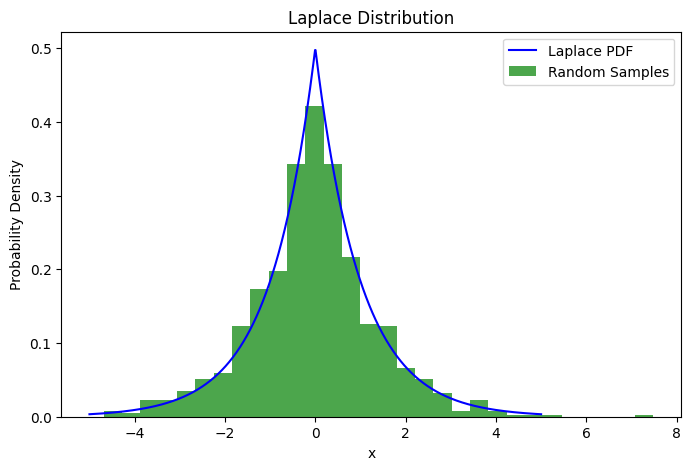

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace

# 定义拉普拉斯分布的概率密度函数
def laplace_pdf(x, mu, b):
    return (1/(2*b)) * np.exp(-np.abs(x - mu) / b)

# 生成一组拉普拉斯分布的随机样本
np.random.seed(42)
laplace_samples = np.random.laplace(loc=0, scale=1, size=1000)

# 生成概率密度函数的 x 值
x_values = np.linspace(-5, 5, 1000)

# 计算概率密度函数的 y 值
pdf_values = laplace_pdf(x_values, mu=0, b=1)

# 绘制概率密度函数和随机样本的直方图
plt.figure(figsize=(8, 5))
plt.plot(x_values, pdf_values, label='Laplace PDF', color='blue')
plt.hist(laplace_samples, bins=30, density=True, alpha=0.7, label='Random Samples', color='green')
plt.title('Laplace Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


In [ ]:
from google.colab import drive

drive.mount('/content/drive')
#/content/drive/MyDrive/

Mounted at /content/drive


Set the environment

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
#RANDOM_SEED = 123

Classify image into train / test

In [ ]:
IMG_PATH = '/content/drive/MyDrive/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    # use _ to check if is reuslt set
    if not CLASS.startswith('_'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        #go through all img files
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 15:
                shutil.copy(img, '/content/drive/MyDrive/brain_tumor_dataset/_TEST/' + CLASS.upper())
            # elif n < 0.8*IMG_NUM:
            else:
                shutil.copy(img, '/content/drive/MyDrive/brain_tumor_dataset/_TRAIN/'+ CLASS.upper())
            # else:
            #     shutil.copy(img, '/content/drive/MyDrive/brain_tumor_dataset/_VAL/'+ CLASS.upper())

Process data

In [ ]:
# TRAIN_DIR = '/content/drive/MyDrive/brain_tumor_dataset/_TRAIN/'
# TEST_DIR = '/content/drive/MyDrive/brain_tumor_dataset/_TEST/'
# VAL_DIR = '/content/drive/MyDrive/brain_tumor_dataset/_VAL/'
# IMG_SIZE = (224,224)

# # use predefined function to load the image data into workspace
# X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
# X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
# X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

In [ ]:
import os
import cv2
import numpy as np

def load_data(directory, img_size, grayscale=True):
    X = []  # store image data
    y = []  # store label data

    labels = os.listdir(directory)
    label_dict = {label: i for i, label in enumerate(labels)}

    for label in labels:
        path = os.path.join(directory, label)
        class_num = label_dict[label]

        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            try:
                # load images
                if grayscale:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                else:
                    img = cv2.imread(img_path)

                # adjust size
                img = cv2.resize(img, img_size)

                # decode and generalize the pixel valye
                if grayscale:
                    img = np.expand_dims(img, axis=-1)  # set channel dimension to grayscale
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = img / 255.0

                #if the label is YES, assign 1, otherwise 0
                X.append(img)
                if labels[class_num]=='YES':
                  y.append(1)
                else:
                  y.append(0)

            except Exception as e:
                print(f"Error reading image {img_path}: {e}")

    return np.array(X), np.array(y), labels


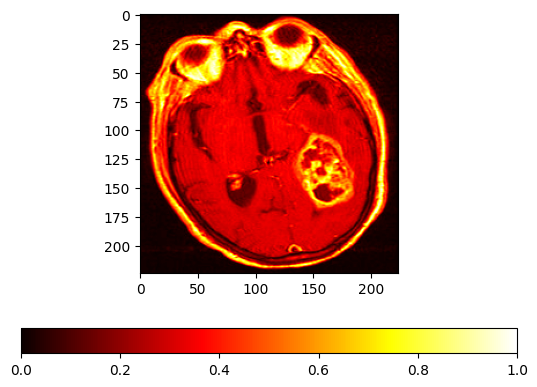

(223, 224, 224, 1)
(223,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
['NO', 'YES']
(30, 224, 224, 1)
(30,)


In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/brain_tumor_dataset/_TRAIN/'
TEST_DIR = '/content/drive/MyDrive/brain_tumor_dataset/_TEST/'
VAL_DIR = '/content/drive/MyDrive/brain_tumor_dataset/_VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
# X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]

indices_2 = np.arange(len(X_test)
)
np.random.shuffle(indices_2)
X_test_shuffled = X_test[indices_2]
y_test_shuffled = y_test[indices_2]

im=plt.imshow(X_train[-1],cmap='hot')
plt.colorbar(im, orientation='horizontal')
plt.show()
print(X_train_shuffled.shape)
print(y_train_shuffled.shape)
print(y_train)
print(labels)
print(X_test_shuffled.shape)
print(y_test_shuffled.shape)
# print(X_val.shape)
# print(y_val.shape)

Output to csv file

In [ ]:
import csv

# suppose X_train and y_train is training set
# save X to X_train.csv
X_train_flattened = X_train_shuffled.reshape(X_train_shuffled.shape[0], -1)
print(X_train_flattened.shape)
# print(X_train[0][0])
# print(X_train[0][0].shape)
with open('/content/drive/MyDrive/X_train.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(X_train_flattened)

# save y to y_train.csv
print(y_train_shuffled)
print(y_train_shuffled.shape)
with open('/content/drive/MyDrive/y_train.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(y_train_shuffled)


X_test_flattened = X_test_shuffled.reshape(X_test_shuffled.shape[0], -1)
print(X_test_flattened.shape)
with open('/content/drive/MyDrive/X_test.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(X_test_flattened)
with open('/content/drive/MyDrive/y_test.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(y_test_shuffled)

(223, 50176)
[1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1
 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1
 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1
 1]
(223,)
(30, 50176)
